In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, MaxPool2D, AveragePooling2D, Flatten, Concatenate, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [36]:
# Завантаження даних та підготовка даних для навчання
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Застосуйте one-hot енкодінг для міток класу
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)

## Inception-ResNets

In [18]:
# Побудова Inception-ResNet блоку
def inception_resnet_block(input_tensor, filters):
    shortcut = input_tensor

    # Inception Block
    x = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(input_tensor)

    x = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(x)

    x = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    # End Inception Block

    x = Activation('relu')(Concatenate()([x, shortcut]))

    return x


In [19]:
# Побудова моделі Inception-ResNet
def inception_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    # Inception-ResNet Block
    for i in range(5):
        x = inception_resnet_block(x, [16, 16, 16, 16])
    # End Inception-ResNet Block

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [20]:
# Налаштування та навчання моделі
model = inception_resnet(input_shape=(28, 28, 1), num_classes=10)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_22 (Conv2D)             (None, 28, 28, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 28, 28, 64)   18496       ['conv2d_22[0][0]']              
                                                                                                  
 conv2d_24 (Conv2D)             (None, 28, 28, 16)   1040        ['conv2d_23[0][0]']              
                                                                                            

                                                                                                  
 dense_2 (Dense)                (None, 512)          14451200    ['flatten_1[0][0]']              
                                                                                                  
 dropout_1 (Dropout)            (None, 512)          0           ['dense_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 10)           5130        ['dropout_1[0][0]']              
                                                                                                  
Total params: 14,497,802
Trainable params: 14,497,514
Non-trainable params: 288
__________________________________________________________________________________________________


In [22]:
model.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 421s 224ms/step - loss: 0.2828 - accuracy: 0.8977
Epoch 2/10
1875/1875 [==============================] - 420s 224ms/step - loss: 0.2233 - accuracy: 0.9180
Epoch 3/10
1875/1875 [==============================] - 421s 224ms/step - loss: 0.1825 - accuracy: 0.9334
Epoch 4/10
1875/1875 [==============================] - 421s 225ms/step - loss: 0.1542 - accuracy: 0.9431
Epoch 5/10
1875/1875 [==============================] - 421s 225ms/step - loss: 0.1245 - accuracy: 0.9541
Epoch 6/10
1875/1875 [==============================] - 422s 225ms/step - loss: 0.1066 - accuracy: 0.9616
Epoch 7/10
1875/1875 [==============================] - 421s 225ms/step - loss: 0.0901 - accuracy: 0.9680
Epoch 8/10
1875/1875 [==============================] - 422s 225ms/step - loss: 0.0787 - accuracy: 0.9719
Epoch 9/10
1875/1875 [==============================] - 422s 225ms/step - loss: 0.0647 - accuracy: 0.9767
Epoch 10/10
1875/1875 [=======================

In [27]:
#model.save('my_model.h5')
model = keras.models.load_model('my_model.h5')

In [24]:
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

313/313 [==============================] - 10s 31ms/step - loss: 0.4319 - accuracy: 0.9208
Train accuracy: 0.9920166730880737
Test accuracy: 0.920799970626831


## Predictictions visualisation

In [25]:
predictions = model.predict(x_test)

313/313 [==============================] - 10s 32ms/step


In [31]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [41]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],100*np.max(predictions_array),class_names[true_label]),color=color)

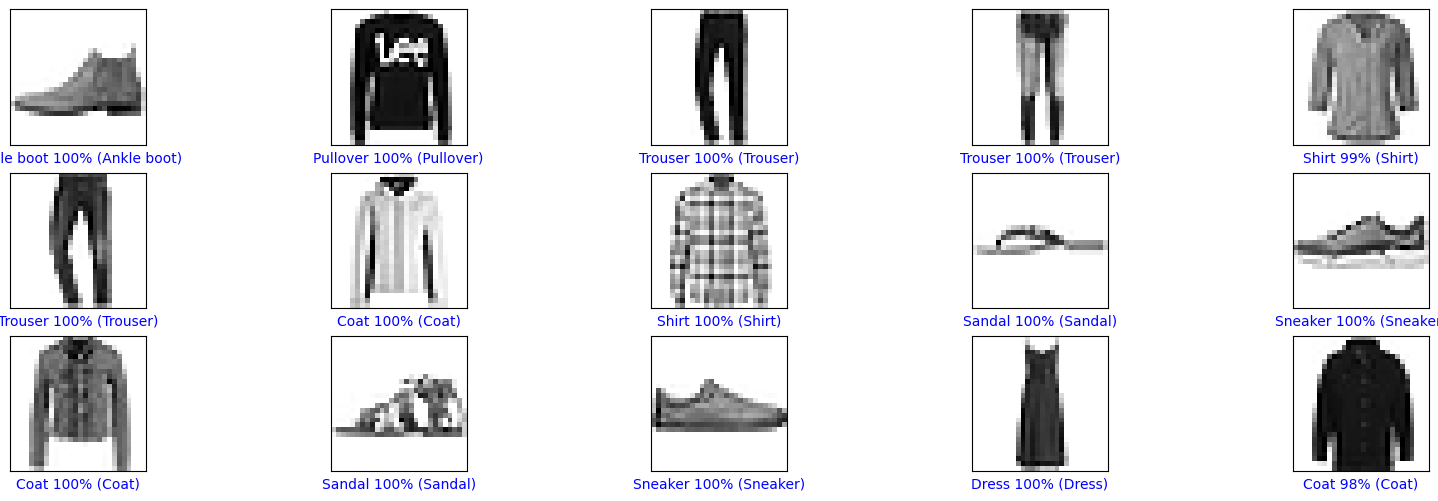

In [42]:
n_rows = 3
n_cols = 5
n_images = n_rows*n_cols
plt.figure(figsize=(2*2*n_cols, 2*n_rows))
for i in range(n_images):
    plt.subplot(n_rows, n_cols, i+1)
    plot_image(i, predictions, y_test, x_test)
plt.show()

## Siamese networks

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (60000, 28, 28, 1) 1.0
Testing (10000, 28, 28, 1) 1.0


In [4]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [5]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

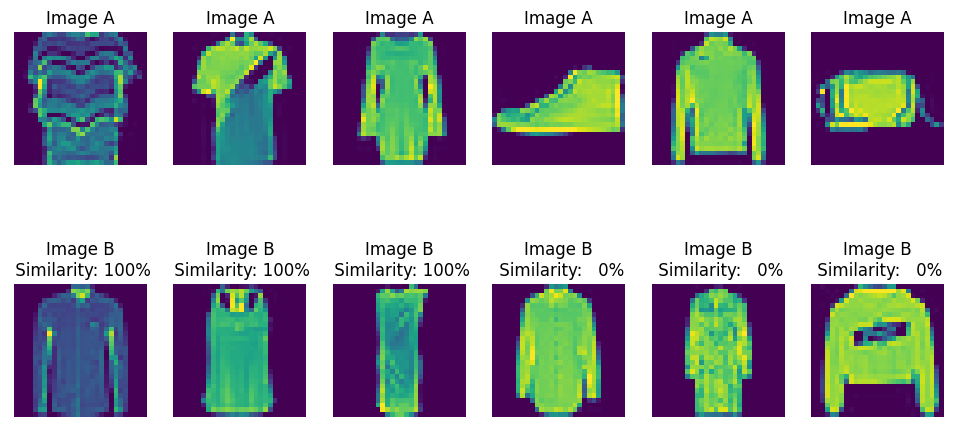

In [6]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [7]:
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24,

In [20]:
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = Concatenate(name='merge_features')([img_a_feat, img_b_feat])
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [21]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

In [22]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig

In [23]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                                               epochs = 10,
                                             verbose = True)

Epoch 1/10
500/500 [==============================] - 17s 31ms/step - loss: 0.6711 - mae: 0.4710
Epoch 2/10
500/500 [==============================] - 16s 32ms/step - loss: 0.5265 - mae: 0.3783
Epoch 3/10
500/500 [==============================] - 16s 32ms/step - loss: 0.4397 - mae: 0.3021
Epoch 4/10
500/500 [==============================] - 16s 32ms/step - loss: 0.4134 - mae: 0.2733
Epoch 5/10
500/500 [==============================] - 16s 32ms/step - loss: 0.3912 - mae: 0.2561
Epoch 6/10
500/500 [==============================] - 16s 33ms/step - loss: 0.3764 - mae: 0.2449
Epoch 7/10
500/500 [==============================] - 17s 34ms/step - loss: 0.3650 - mae: 0.2365
Epoch 8/10
500/500 [==============================] - 16s 33ms/step - loss: 0.3647 - mae: 0.2345
Epoch 9/10
500/500 [==============================] - 16s 32ms/step - loss: 0.3658 - mae: 0.2345
Epoch 10/10
500/500 [==============================] - 16s 31ms/step - loss: 0.3547 - mae: 0.2283


In [24]:
similarity_model.save('my_model2.h5')
#similarity_model = keras.models.load_model('my_model2.h5')

1/1 [==============================] - 0s 157ms/step


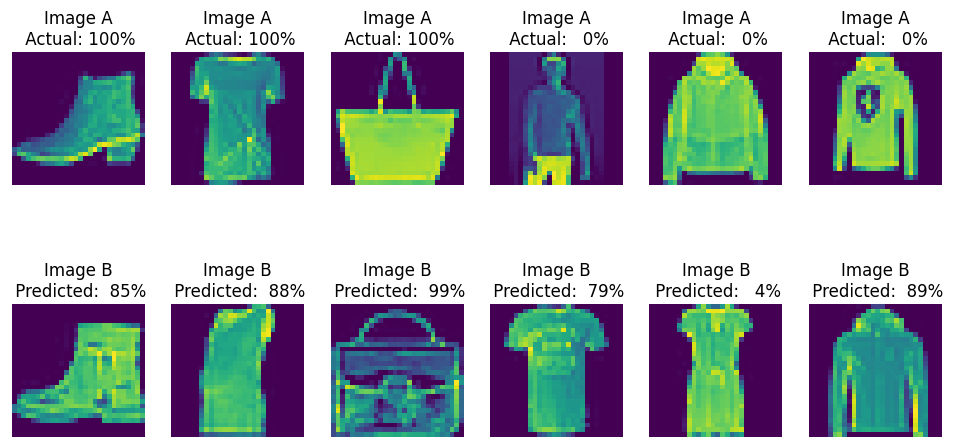

In [25]:
_ = show_model_output()

## Visualization with t-SNE

In [28]:
x_test_features = model.predict(x_test, verbose=True, batch_size=128)

79/79 [==============================] - 11s 134ms/step


In [29]:
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 0.506s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.371s
[t-SNE] Iteration 50: error = 73.1832504, gradient norm = 0.0229981 (50 iterations in 1.331s)
[t-SNE] It

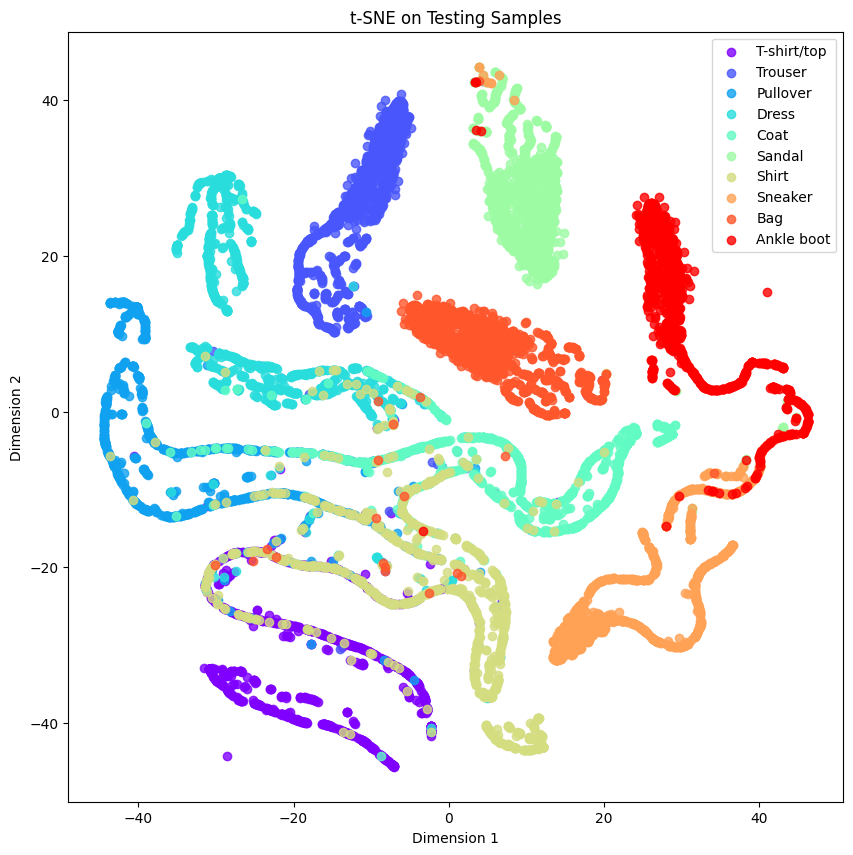

In [32]:
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, class_names)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes_dist.png')
plt.show(block=False)